In [1]:
pip install pandas numpy matplotlib seaborn nltk wordcloud

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8d/9d/d06860390f9d154fa884f1740a5456378fb153ff57443c91a4a32bab7092/matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/90/be/1a7a488f5edcfae6746ffb91e792a1795b6cc058364ea6888b3878d3476f/wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/99/e6/d1196696

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK 데이터 다운로드 (처음 한 번만 실행)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /data/ephemeral/home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/ephemeral/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# CSV 파일로 된 텍스트 데이터 로드 (예: 대화와 요약 데이터)
df = pd.read_csv('/data/ephemeral/home/data/data/train.csv')

# 데이터프레임의 처음 몇 줄 확인    
df.head(5)

,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...",건강검진 받기
1,train_1,"#Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,백신
2,train_2,"#Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...",열쇠 찾기
3,train_3,#Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...,#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,여자친구가 있다
4,train_4,"#Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,댄스


# 마스킹 패턴 찾기

In [4]:
import re
import pandas as pd

def reg_masking(text):
    pattern = r"#\w+#"  # #로 둘러싸인 단어들을 찾는 정규식 패턴
    masked = re.findall(pattern, text)
    return set(masked)  # 중복을 제거하고 고유한 토큰들의 집합을 반환


# `reg_masking`을 호출하고 결과를 문자열로 변환하여 저장
df['masked_patterns'] = df['dialogue'].apply(lambda x: str(reg_masking(x)))

# 문자열로 저장된 집합을 실제 집합(set)으로 변환
df['masked_patterns'] = df['masked_patterns'].apply(eval)

# 모든 행에 있는 세트들의 합집합을 구함
all_unique_tokens = set.union(*df['masked_patterns'])

print("고유한 특수 토큰들:", all_unique_tokens)


고유한 특수 토큰들: {'#DateOfBirth#', '#Person4#', '#Person2#', '#SSN#', '#CarNumber#', '#Email#', '#Person5#', '#Address#', '#Person#', '#Person7#', '#PassportNumber#', '#CardNumber#', '#Person1#', '#Person6#', '#PhoneNumber#', '#Person3#'}


# dialogue, summary 길이

In [6]:
import re
import pandas as pd

# 제거할 특수 토큰 리스트
special_tokens_all = ['#CarNumber#', '#SSN#', '#Person4#:', '#Person7#:', '#PhoneNumber#', '#Person3#:', '#PassportNumber#', '#Email#', '#Person2#:', '#Person#:', '#Person6#:', '#CardNumber#', '#Address#', '#Person5#:', '#DateOfBirth#', '#Person1#:']
special_tokens_n = ['\n']
special_tokens = ['\n', '#CarNumber#', '#SSN#', '#PhoneNumber#', '#PassportNumber#', '#Email#','#CardNumber#', '#Address#','#DateOfBirth#', ':']
speaker_tokens = ['#Person1#:', '#Person2#:', '#Person3#:', '#Person4#:', '#Person5#:', '#Person6#:', '#Person7#:']

# 특수 토큰을 제거하는 함수 정의
def remove_special_tokens(text):
    for token in special_tokens:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

# 대화의 turn 수를 세는 함수
def count_dialogue_turns(text):
    # 화자 태그 패턴을 정의합니다 (예: #Person1#, #Person2# 등)
    speaker_pattern = r"#Person\d+#"
    
    # 모든 화자 태그를 찾아 리스트로 반환합니다
    speakers = re.findall(speaker_pattern, text)
    
    # 화자가 변경될 때마다 턴을 카운트합니다
    turn_count = 0
    current_speaker = None
    
    for speaker in speakers:
        if speaker != current_speaker:
            turn_count += 1
            current_speaker = speaker
            
    return turn_count

# '\n'을 제거하는 함수 정의
def remove_special_tokens_n(text):
    for token in special_tokens_n:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

#  제거하는 함수 정의
def remove_speaker_tokens(text):
    for token in speaker_tokens:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

def count_speakers(text):
    # 화자 식별자에 대한 정규식 패턴 생성
    pattern = r'(' + '|'.join(re.escape(token) for token in speaker_tokens) + ')'
    # 텍스트에서 패턴에 매칭되는 모든 항목을 찾아 집합으로 변환
    speakers = set(re.findall(pattern, text))
    # 집합의 크기(고유 화자 수) 반환
    return len(speakers)

# 대화 및 요약에서 특수 토큰을 제거한 텍스트 생성
df['cleaned_dialogue'] = df['dialogue'].apply(remove_special_tokens_n)
df['cleaned_summary'] = df['summary'].apply(remove_special_tokens_n)

# 대화의 turn 수 계산
df['dialogue_turns'] = df['dialogue'].apply(count_dialogue_turns)
df['number_of_speakers'] = df['dialogue'].apply(count_speakers)

# 텍스트 길이 계산
df['cleaned_dialogue2'] = df['cleaned_dialogue'].apply(remove_speaker_tokens)
df['text_length'] = df['cleaned_dialogue2'].apply(len)
df['summary_length'] = df['cleaned_summary'].apply(len)

# 텍스트 길이 및 turn 수, 화자 수 통계 출력
print(df[['dialogue_turns', 'number_of_speakers','text_length', 'summary_length']].describe())


       dialogue_turns  number_of_speakers   text_length  summary_length
count    12457.000000        12457.000000  12457.000000    12457.000000
mean         9.485350            2.011801    335.392791       87.396885
std          4.150736            0.130849    187.738251       37.640887
min          2.000000            2.000000     67.000000       19.000000
25%          7.000000            2.000000    211.000000       61.000000
50%          9.000000            2.000000    294.000000       80.000000
75%         12.000000            2.000000    418.000000      106.000000
max         61.000000            7.000000   2184.000000      478.000000


In [8]:
df[['dialogue_turns', 'number_of_speakers','text_length', 'summary_length']].describe()

,dialogue_turns,number_of_speakers,text_length,summary_length
count,12457.000000,12457.000000,12457.000000,12457.000000
mean,9.485350,2.011801,335.392791,87.396885
std,4.150736,0.130849,187.738251,37.640887
min,2.000000,2.000000,67.000000,19.000000
25%,7.000000,2.000000,211.000000,61.000000
50%,9.000000,2.000000,294.000000,80.000000
75%,12.000000,2.000000,418.000000,106.000000
max,61.000000,7.000000,2184.000000,478.000000


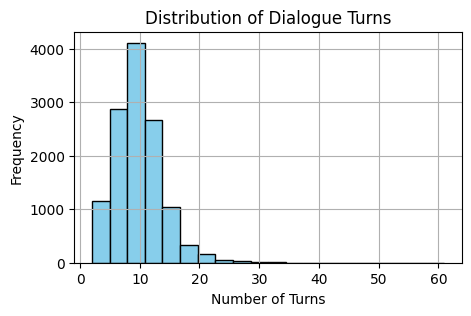

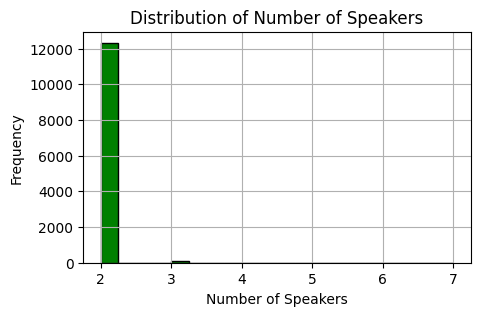

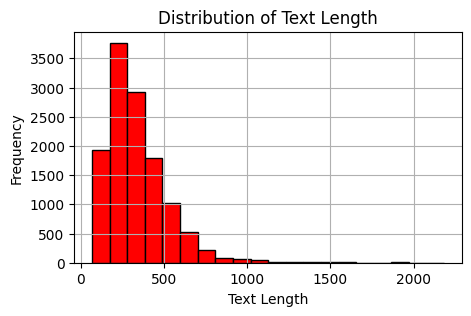

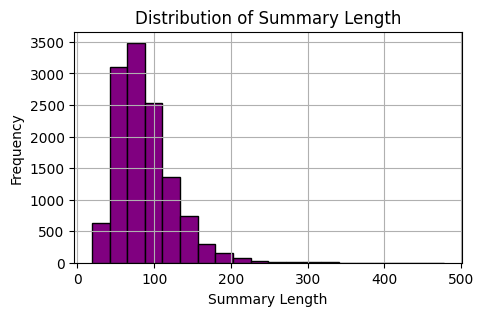

In [7]:
import matplotlib.pyplot as plt

# 'dialogue_turns'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['dialogue_turns'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Dialogue Turns')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'number_of_speakers'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['number_of_speakers'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Number of Speakers')
plt.xlabel('Number of Speakers')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'text_length'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['text_length'], bins=20, color='red', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'summary_length'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['summary_length'], bins=20, color='purple', edgecolor='black')
plt.title('Distribution of Summary Length')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [64]:
import pandas as pd

# 출력할 최대 열 수 설정
pd.set_option('display.max_columns', None)

# 출력할 최대 행 수 설정
pd.set_option('display.max_rows', None)

# 첫 번째 행 출력
df.iloc[0]['dialogue']

'#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?\n#Person2#: 건강검진을 받는 것이 좋을 것 같아서요.\n#Person1#: 그렇군요, 당신은 5년 동안 건강검진을 받지 않았습니다. 매년 받아야 합니다.\n#Person2#: 알고 있습니다. 하지만 아무 문제가 없다면 왜 의사를 만나러 가야 하나요?\n#Person1#: 심각한 질병을 피하는 가장 좋은 방법은 이를 조기에 발견하는 것입니다. 그러니 당신의 건강을 위해 최소한 매년 한 번은 오세요.\n#Person2#: 알겠습니다.\n#Person1#: 여기 보세요. 당신의 눈과 귀는 괜찮아 보입니다. 깊게 숨을 들이쉬세요. 스미스씨, 담배 피우시나요?\n#Person2#: 네.\n#Person1#: 당신도 알다시피, 담배는 폐암과 심장병의 주요 원인입니다. 정말로 끊으셔야 합니다. \n#Person2#: 수백 번 시도했지만, 습관을 버리는 것이 어렵습니다.\n#Person1#: 우리는 도움이 될 수 있는 수업과 약물들을 제공하고 있습니다. 나가기 전에 더 많은 정보를 드리겠습니다.\n#Person2#: 알겠습니다, 감사합니다, 의사선생님.'

In [54]:
df.iloc[1]['cleaned_dialogue2']

' 안녕하세요, 파커 부인, 어떻게 지내셨나요? 안녕하세요, 피터스 박사님. 잘 지냈습니다, 감사합니다. 리키와 함께 백신 접종을 위해 왔습니다. 좋습니다. 백신 접종 기록을 보니, 리키는 이미 소아마비, 디프테리아, B형 간염 백신을 맞았군요. 그는 14개월이므로, 이제 A형 간염, 수두, 홍역 백신을 맞아야 합니다. 풍진과 볼거리는 어떻게 되나요? 지금은 이 백신들만 접종할 수 있고, 몇 주 후에 나머지를 접종할 수 있습니다. 좋습니다. 박사님, 저도 디프테리아 예방접종이 필요할 것 같아요. 마지막으로 맞은 게 아마도 15년 전이었던 것 같아요! 저희가 기록을 확인하고 간호사에게 부스터를 접종하도록 하겠습니다. 이제, 리키의 팔을 꽉 잡아주세요, 조금 찌릿할 수 있습니다.'

In [7]:
df.iloc[3]['summary']

'#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실을 #Person1#에게 말하지 않았기 때문에 화가 났다.'

In [56]:
df.iloc[1]['cleaned_summary']

'파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후 리키에게 백신을 접종했다.'

In [65]:
df.head()

,fname,dialogue,summary,topic,masked_patterns,cleaned_dialogue,cleaned_summary,dialogue_turns,number_of_speakers,cleaned_dialogue2,text_length,summary_length
0,train_0,"#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...",건강검진 받기,"{#Person2#, #Person1#}","안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?\n 건강검진을...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...",12,2,"안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요? 건강검진을 받...",444,107
1,train_1,"#Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,백신,"{#Person2#, #Person1#}","안녕하세요, 파커 부인, 어떻게 지내셨나요?\n 안녕하세요, 피터스 박사님. 잘 ...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,7,2,"안녕하세요, 파커 부인, 어떻게 지내셨나요? 안녕하세요, 피터스 박사님. 잘 지냈...",381,61
2,train_2,"#Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...",열쇠 찾기,"{#Person2#, #Person1#}","실례합니다, 열쇠 한 묶음 보셨나요?\n 어떤 종류의 열쇠인가요?\n 5개의 열쇠...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...",10,2,"실례합니다, 열쇠 한 묶음 보셨나요? 어떤 종류의 열쇠인가요? 5개의 열쇠와 작은...",231,62
3,train_3,#Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...,#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,여자친구가 있다,"{#Person2#, #Person1#}","왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n 미안해, 너가 이미 알고 있다...",#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,11,2,"왜 너는 여자친구가 있다는 걸 말해주지 않았어? 미안해, 너가 이미 알고 있다고 ...",258,78
4,train_4,"#Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,댄스,"{#Person2#, #Person1#}","안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,7,2,"안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...",237,51
